In [2]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Keras neural network model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras import optimizers, regularizers, initializers
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization

# Scikit-sklearn preprocessing modules
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Matplotlib and plotly modules
import matplotlib.pyplot as plt
from matplotlib import ticker
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

Using TensorFlow backend.


In [6]:
# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 14
    }

plt.rc('font', **font)
plt.rc('text', usetex=True)

In [7]:
df_total = pd.read_csv("data/total_300.csv")

In [8]:
df_total.columns

Index(['velocity:0', 'velocity:1', 'force:0', 'force:1',
       'total displacement:0', 'total displacement:1', 'temperature',
       'temp_power', 'temp_pressure', 'temp_density', 'node number',
       'plastic strain', 'plastic strain-rate', 'strain-rate II log10',
       'strain-rate XX', 'elastic_strain XX', 'strain-rate ZZ',
       'elastic_strain ZZ', 'strain-rate XZ', 'elastic_strain XZ', 'strain I',
       'strain II', 'strain XX', 'strain ZZ', 'strain XZ', 'stress I',
       'stress II', 'stress XX', 'stress ZZ', 'stress XZ', 'density',
       'thermal_stress', 'energy_total_vol_dev', 'energy_volumetric',
       'energy_deviatoric', 'energy_thermal', 'energy_elastic', 'coordinate:0',
       'coordinate:1'],
      dtype='object')

In [9]:
df_total = df_total.drop_duplicates()

In [10]:
threshold = 0.15
df_total['plastic strain'] = np.where(df_total['plastic strain'] > threshold, 1,0)

In [ ]:
df_total.head(5)

In [11]:
feature_cols = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']

dropped_cols = ['plastic strain', 'plastic strain-rate', 'strain-rate II log10', 'strain-rate XX',
       'elastic_strain XX', 'strain-rate ZZ', 'elastic_strain ZZ',
       'strain-rate XZ', 'elastic_strain XZ', 'strain I', 'strain II',
       'strain XX', 'strain ZZ', 'strain XZ', 'coordinate:0', 'coordinate:1', 'force:0', 'force:1', 
       'total displacement:0', 'total displacement:1', 'stress I', 'stress II', 'energy_volumetric', 
       'energy_deviatoric','energy_thermal', 'energy_elastic', 'thermal_stress',
       'energy_total_vol_dev', 'temp_power', 'temp_pressure', 'temp_density', 'node number']

In [12]:
def drop_and_split_coloumns(df):
    Y = df['plastic strain']
    df = df[feature_cols]
    X = df
    xtrain, xval, ytrain, yval = train_test_split(X, Y, test_size=0.30, random_state=42)
    
    return xtrain, xval, ytrain, yval, df

In [13]:
xtrain, xval, ytrain, yval, df_total = drop_and_split_coloumns(df_total)

In [14]:
def scale_feature(features):    
    mms = StandardScaler()
    scaled_features = mms.fit_transform(features)
    return scaled_features, mms

In [15]:
mms = [None, None]
xtrain, mms[0] = scale_feature(xtrain)
xval, mms[1] = scale_feature(xval)

## Neural network model

In [16]:
class build_neural_network:
    
    def __init__(self, model_name, xtrain, ytrain, xval, yval):
        self.model_name = model_name
        self.xtrain = xtrain
        self.ytrain = to_categorical(ytrain)
        self.xval = xval
        self.yval = to_categorical(yval)
        self.input_shape = np.shape(xtrain)[1]
        self.output_shape = np.shape(self.ytrain)[1]
        self.model = None
        self.ypred = None
        self.weight_path = "./weights/"
            
    def get_model_weights(self):
        return self.model.get_weights()

    def create_model(self):
        self.model = Sequential()
        self.model.add(Dense(self.input_shape, 
                             kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed = 2018), 
                             activation = 'relu', name='layer_1',
                             input_shape = (self.input_shape,)))
        
        self.model.add(Dense(12, activation = 'relu', name='layer_2'))
            
        self.model.add(Dense(self.output_shape, activation="softmax", name='Output_layer'))
        self.model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()
    
    def train_model(self, training_epochs):
        self.create_model()
        
        filepath = self.weight_path + str(self.model_name) + '.hdf5'
        
        if not os.path.exists(self.weight_path):
            os.makedirs(self.weight_path)
        
        checkpoint = ModelCheckpoint(filepath, verbose=0, period = training_epochs)
        self.model.fit(self.xtrain, self.ytrain, batch_size = 10, epochs = training_epochs, 
        callbacks = [checkpoint], validation_data=(self.xval, self.yval))
        
        self.save_model()
        
    def save_model(self):
        file_name = str(self.weight_path) + str(self.model_name)
        self.model.save(file_name)
    
    def predict(self, xtest):
        self.ypred = self.model.predict(xtest)
        
    def classification_report(self, xtest, ytest):
        self.predict(xtest)
        Y_test_class = np.argmax(ytest, axis = 1)
        Y_pred_class = np.argmax(self.ypred, axis = 1)
        
        print('Accuracy: {}'.format(accuracy_score(Y_test_class, Y_pred_class)))
        print('Classification report: \n {} \n'.format(classification_report(Y_test_class, Y_pred_class)))
        print('Confusion matrix: {}'.format(confusion_matrix(Y_test_class, Y_pred_class)))
    
    def set_color_bar(self, a, fig, cbar_min, cbar_max):
        fig.subplots_adjust(hspace=0.5)
        tick_v = np.linspace(cbar_min, cbar_max, 20, endpoint=True)
        fig.colorbar(a, orientation='vertical', ticks = tick_v)
    
    def plot_model_weights(self, figsize):    
        model_weights = []
        weights = self.get_model_weights()
        layer_1_weights = weights[0]
        layer_2_weights = weights[4]    
        cbar_max = np.amax([np.amax(layer_1_weights), np.amax(layer_2_weights)])
        cbar_min = np.amin([np.amin(layer_1_weights), np.amin(layer_2_weights)])
        
        # Layer-1
        fig = plt.figure(figsize= figsize)
        plt.subplot(1,2, 1)
        mesh_plot = plt.pcolormesh(np.transpose(weights[0]), clim=(cbar_min, cbar_max))
        labels = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']
        plt.xticks([0.5+float(x) for x in range(0, len(labels))], labels, rotation='vertical')
        plt.yticks([0.5+float(x) for x in range(0, len(labels))], list(range(1,13)))
        plt.ylabel('Hidden Units')
        
        # Output layer
        plt.subplot(1, 2, 2)
        bb = np.reshape(weights[1], (self.input_shape, 1))
        mesh_plot = plt.pcolormesh(bb, clim=(cbar_min, cbar_max))
        plt.xticks([0.5],['Output Unit'],rotation='vertical')
        plt.yticks([0.5+float(x) for x in range(0, len(labels))], list(range(1,13)))
        self.set_color_bar(mesh_plot, fig, cbar_min, cbar_max)

        plt.tight_layout()
        plt.show()


In [17]:
deviatoric = build_neural_network("total_200", xtrain, ytrain, xval, yval)

In [18]:
deviatoric.train_model(10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
layer_2 (Dense)              (None, 12)                96        
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 26        
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________
Train on 1125781 samples, validate on 482478 samples
Epoch 1/10
1125781/1125781 [==============================] - 362s - loss: 0.0497 - acc: 0.9827 - val_loss: 0.0455 - val_acc: 0.9834
Epoch 2/10
1125781/1125781 [==============================] - 382s - loss: 0.0433 - acc: 0.9846 - val_loss: 0.0421 - val_acc: 0.9850
Epoch 3/10
1125781/1125781 [==============================] - 401s - loss: 0.0419 - acc: 

## Test data preparation

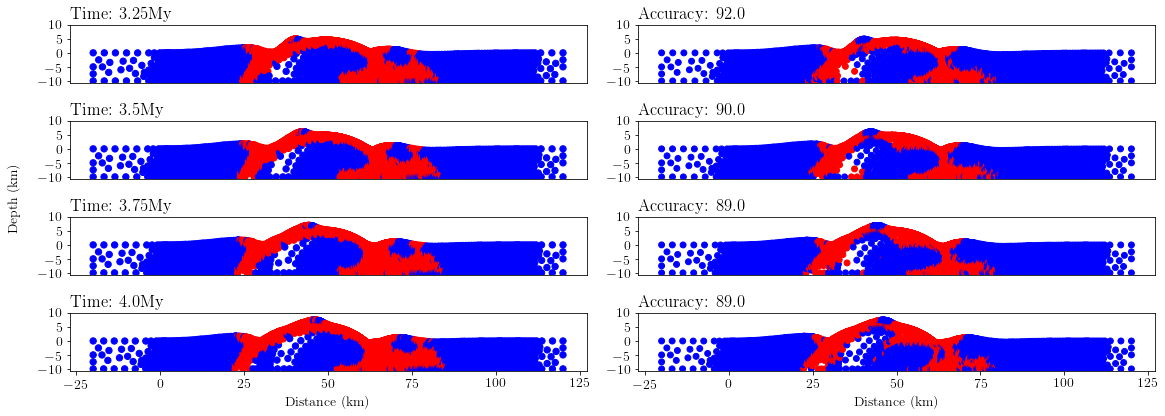

In [45]:
times = [325, 350, 375, 400]
fig = plt.figure(figsize = (16,6))

for i, val  in enumerate(times):
    
    file_name = "new_data/totoal."+ str(val) +".csv"
    df_test = pd.read_csv(file_name)
    df_test = df_test.drop_duplicates()
    threshold = 0.15
    df_test['plastic strain'] = np.where(df_test['plastic strain'] > threshold, 1,0)
    xtest = df_test[feature_cols]
    ytest = df_test['plastic strain']
    scale = mms[0]
    xtest = scale.fit_transform(xtest)
    ypred = np.argmax(deviatoric.model.predict(xtest), axis = 1)
    acc = accuracy_score(ytest, ypred)
    
    ## Plot figure
    plt.subplot(4,2, (i+(i+1)))
    plt.scatter(x = df_test['coordinate:0']/1e3, y= df_test['coordinate:1']/1e3, 
                c = df_test['plastic strain'], vmin=0, vmax=1, s = 40 , cmap='bwr')
    plt.title('Time: ' + str(val/100.0)+'My', loc='left')
    plt.yticks([10, 5, 0, -5, -10])
    if (i+2) == 5:
        plt.xticks([-25, 0, 25, 50, 75, 100, 125])
        plt.xlabel('Distance (km)')
    else:
        plt.xticks([])
        
    
    plt.subplot(4,2,(i+(i+2)))
    plt.scatter(df_test['coordinate:0']/1e3, y= df_test['coordinate:1']/1e3, c = ypred, 
                vmin=0, vmax=1, s=35, cmap='bwr')
    plt.title('Accuracy: '+ str(round(acc, 2)*100) + '%', loc='left')
    plt.yticks([10, 5, 0, -5, -10])
    
    if (i+2) == 5:
        plt.xticks([-25, 0, 25, 50, 75, 100, 125])
        plt.xlabel('Distance (km)')
    else:
        plt.xticks([])
        
plt.text(-215, 60, 'Depth (km)', rotation=90)
plt.tight_layout()
fig.savefig('original_vs_predicted.png')
plt.show()

In [20]:
ytest = df_test['plastic strain']
print('Accuracy: {}\n'.format(accuracy_score(ytest, ypred)))
print('Classification report: \n {}\n'.format(classification_report(ytest, ypred)))
print('Confusion matrix: \n{}'.format(confusion_matrix(ytest, ypred)))

Accuracy: 0.9117996201329535

Classification report: 
              precision    recall  f1-score   support

          0       0.81      0.98      0.89      2963
          1       0.99      0.88      0.93      5461

avg / total       0.92      0.91      0.91      8424


Confusion matrix: 
[[2897   66]
 [ 677 4784]]


## Load model 

In [4]:
model = load_model('./weights/total_200.hdf5')

## Add application to real world

In [ ]:
app_feature_cols = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']